# Crimes in Boston

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from ast import literal_eval
import seaborn as sns 
import folium
from folium import plugins
from folium.plugins import HeatMap

In [2]:
data = pd.read_csv('crime.csv', engine='python')

First is to explore the dataset 

In [3]:
data.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,NaN,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319073 entries, 0 to 319072
Data columns (total 17 columns):
INCIDENT_NUMBER        319073 non-null object
OFFENSE_CODE           319073 non-null int64
OFFENSE_CODE_GROUP     319073 non-null object
OFFENSE_DESCRIPTION    319073 non-null object
DISTRICT               317308 non-null object
REPORTING_AREA         319073 non-null object
SHOOTING               1019 non-null object
OCCURRED_ON_DATE       319073 non-null object
YEAR                   319073 non-null int64
MONTH                  319073 non-null int64
DAY_OF_WEEK            319073 non-null object
HOUR                   319073 non-null int64
UCR_PART               318983 non-null object
STREET                 308202 non-null object
Lat                    299074 non-null float64
Long                   299074 non-null float64
Location               319073 non-null object
dtypes: float64(2), int64(4), object(11)
memory usage: 41.4+ MB


The first column is INCIDENT_NUMBER which should be unique for each case. If so it is possible to remove 

In [5]:
len(data['INCIDENT_NUMBER'])==len(set(data['INCIDENT_NUMBER']))

False

Sadly there are duplicated values. So for now just keep this column

Next is to handle missing values

In [6]:
data.isnull().sum()

INCIDENT_NUMBER             0
OFFENSE_CODE                0
OFFENSE_CODE_GROUP          0
OFFENSE_DESCRIPTION         0
DISTRICT                 1765
REPORTING_AREA              0
SHOOTING               318054
OCCURRED_ON_DATE            0
YEAR                        0
MONTH                       0
DAY_OF_WEEK                 0
HOUR                        0
UCR_PART                   90
STREET                  10871
Lat                     19999
Long                    19999
Location                    0
dtype: int64

<br>First particular column needed to be handled is SHOOTING. There are many missing values. 
<br>Need to check if missing values in SHOOTING means the case does not involve shooting. If so then need to keep it

In [7]:
set(data['SHOOTING'])

{'Y', nan}

There are only two options in SHOOTING, Y and missing 

In [8]:
set(data.loc[data['SHOOTING'].isnull(),'OFFENSE_CODE_GROUP'])

{'Aggravated Assault',
 'Aircraft',
 'Arson',
 'Assembly or Gathering Violations',
 'Auto Theft',
 'Auto Theft Recovery',
 'Ballistics',
 'Biological Threat',
 'Bomb Hoax',
 'Burglary - No Property Taken',
 'Commercial Burglary',
 'Confidence Games',
 'Counterfeiting',
 'Criminal Harassment',
 'Disorderly Conduct',
 'Drug Violation',
 'Embezzlement',
 'Evading Fare',
 'Explosives',
 'Fire Related Reports',
 'Firearm Discovery',
 'Firearm Violations',
 'Fraud',
 'Gambling',
 'HOME INVASION',
 'HUMAN TRAFFICKING',
 'HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE',
 'Harassment',
 'Harbor Related Incidents',
 'Homicide',
 'INVESTIGATE PERSON',
 'Investigate Person',
 'Investigate Property',
 'Landlord/Tenant Disputes',
 'Larceny',
 'Larceny From Motor Vehicle',
 'License Plate Related Incidents',
 'License Violation',
 'Liquor Violation',
 'Manslaughter',
 'Medical Assistance',
 'Missing Person Located',
 'Missing Person Reported',
 'Motor Vehicle Accident Response',
 'Offenses Against Child /

In [9]:
set(data.loc[~data['SHOOTING'].isnull(),'OFFENSE_CODE_GROUP'])

{'Aggravated Assault',
 'Ballistics',
 'Disorderly Conduct',
 'Drug Violation',
 'Firearm Discovery',
 'Firearm Violations',
 'HOME INVASION',
 'Homicide',
 'Investigate Person',
 'Investigate Property',
 'Manslaughter',
 'Medical Assistance',
 'Missing Person Located',
 'Motor Vehicle Accident Response',
 'Other',
 'Police Service Incidents',
 'Property Found',
 'Property Lost',
 'Property Related Damage',
 'Recovered Stolen Property',
 'Robbery',
 'Search Warrants',
 'Simple Assault',
 'Towed',
 'Vandalism',
 'Violations',
 'Warrant Arrests'}

Comparing the OFFENSE_CODE_GROUP with SHOOTING ='Y' and missing value in SHOOTING, it is reasonableto say that missing value means there is no shooting involved. Replace those missing with 'N' 

In [10]:
data.loc[data['SHOOTING'].isnull(),'SHOOTING']='N'

Next is to handle STREET, Lat and Long
<br>However, there is no missing value for Location which seems store lat and long.
<br>After confirming, information in Location can be used to replace missing values in Lat and Long.

In [11]:
data['Location'] = [literal_eval(x) for x in data['Location']]

In [12]:
data[['Lat_loc','Long_loc']] = pd.DataFrame(data['Location'].to_list(),index=data.index)

In [13]:
all(data.loc[~data['Lat'].isnull(),'Lat']==data.loc[~data['Lat'].isnull(),'Lat_loc'])

True

In [14]:
all(data.loc[~data['Long'].isnull(),'Long']==data.loc[~data['Long'].isnull(),'Long_loc'])

True

So for non missing values in Lat and Lot columns, their values match with Location 
<br>As a result, Lat and Long from Location are used to replace missing values in Lat and Long colunms

In [15]:
data.loc[data['Lat'].isnull(),'Lat']=data['Lat_loc']

In [16]:
data.loc[data['Long'].isnull(),'Long']=data['Long_loc']

Finally remains STREET, DISTRICT, and UCR_PART
<br>Since we have lat and long, it is possible to remove STREET and DISTRICT columns. But for now will just keep them from the dataset with missing values.
<br>For UCR_PART, since there are only 90 missing values, there should be no problem affecting the analysis. Therefore just leave it 

Now can remove Lat_loc, Long_loc and Location columns 

In [17]:
data.drop(['Lat_loc','Long_loc','Location'],axis=1,inplace=True)

In [18]:
data.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,N,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371
1,I182070943,1402,Vandalism,VANDALISM,C11,347,N,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,N,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,N,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,N,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361


In [19]:
data.describe()

,OFFENSE_CODE,YEAR,MONTH,HOUR,Lat,Long
count,319073.000000,319073.000000,319073.000000,319073.000000,319073.000000,319073.000000
mean,2317.546956,2016.560586,6.609719,13.118205,39.568449,-66.463852
std,1185.285543,0.996344,3.273691,6.294205,10.443561,17.516694
min,111.000000,2015.000000,1.000000,0.000000,-1.000000,-71.178674
25%,1001.000000,2016.000000,4.000000,9.000000,42.290736,-71.095264
50%,2907.000000,2017.000000,7.000000,14.000000,42.321060,-71.075608
75%,3201.000000,2017.000000,9.000000,18.000000,42.347174,-71.060005
max,3831.000000,2018.000000,12.000000,23.000000,42.395042,0.000000


There are some records with abnormal Lat and Long. Eg. Lat =1 and Long =0
<br>Since the dataset only covers Boston, the variation of Lat and Long should be very small
<br>Need to consider the accuracy and thus possible to delete 

In [20]:
data[((data['Lat']<42)|(data['Lat']>43))].describe()

,OFFENSE_CODE,YEAR,MONTH,HOUR,Lat,Long
count,20744.000000,20744.000000,20744.000000,20744.000000,20744.000000,20744.000000
mean,2623.207819,2016.661830,6.559246,13.015426,-0.035914,-0.035914
std,1174.358413,0.931298,3.208988,6.509395,0.186080,0.186080
min,111.000000,2015.000000,1.000000,0.000000,-1.000000,-1.000000
25%,1841.000000,2016.000000,4.000000,9.000000,0.000000,0.000000
50%,3018.000000,2017.000000,7.000000,14.000000,0.000000,0.000000
75%,3802.000000,2017.000000,9.000000,18.000000,0.000000,0.000000
max,3831.000000,2018.000000,12.000000,23.000000,0.000000,0.000000


It is pretty sure that records with abnormal Lat or Long are inaccurate
<br>Since there are around 10% of overall records, these records will be kept but will not be used when location is studied in later stage

Now we can explore the dataset

In [21]:
print(min(data['OCCURRED_ON_DATE']))
print(max(data['OCCURRED_ON_DATE']))

2015-06-15 00:00:00
2018-09-03 21:25:00


First study is the offense_code_group 

In [22]:
data.groupby(['OFFENSE_CODE_GROUP']).agg({'INCIDENT_NUMBER':'count'}).rename(columns={'INCIDENT_NUMBER':'count'}).sort_values(by='count',ascending=False).head(10)

,count
OFFENSE_CODE_GROUP,
Motor Vehicle Accident Response,37132
Larceny,25935
Medical Assistance,23540
Investigate Person,18750
Other,18075
Drug Violation,16548
Simple Assault,15826
Vandalism,15415
Verbal Disputes,13099


Top three most frequent offenses: Motor Vehicle Accident Response, Larceny and Medical Assistance
<br>Top three contributes more than 20% of total

How about we only consider crimes with shooting?

In [23]:
data.groupby(['SHOOTING']).agg({'INCIDENT_NUMBER':'count'}).rename(columns={'INCIDENT_NUMBER':'count'})

,count
SHOOTING,
N,318054
Y,1019


Luckily, there are only slightly over 1000 crimes involving shooting

In [24]:
data[data['SHOOTING']=='Y'].groupby(['OFFENSE_CODE_GROUP']).agg({'INCIDENT_NUMBER':'count'}).rename(columns={'INCIDENT_NUMBER':'count'}).sort_values(by='count',ascending=False).head(10)

,count
OFFENSE_CODE_GROUP,
Aggravated Assault,523
Homicide,121
Warrant Arrests,73
Firearm Violations,71
Ballistics,42
Drug Violation,32
Search Warrants,29
Medical Assistance,20
Robbery,19


And already over half is aggravated assault.

Next is to study the frequent timeslot for crime
<br>Also, overall crimes and involved shooting are studied

In [25]:
data.groupby(['DAY_OF_WEEK','HOUR']).agg({'INCIDENT_NUMBER':'count'}).rename(columns={'INCIDENT_NUMBER':'count'}).sort_values(by='count',ascending=False).head(10)

count
DAY_OF_WEEK HOUR       
Monday      17     3254
Friday      17     3252
Tuesday     17     3241
            18     3218
Wednesday   17     3153
            18     3098
Monday      18     3089
Tuesday     16     3080
Friday      16     3073
Wednesday   16     3053

It is a bit weired that top ten frequent are between 16 and 18 and only during weekday 

In [26]:
data[data['SHOOTING']=='Y'].groupby(['DAY_OF_WEEK','HOUR']).agg({'INCIDENT_NUMBER':'count'}).rename(columns={'INCIDENT_NUMBER':'count'}).sort_values(by='count',ascending=False).head(10)

count
DAY_OF_WEEK HOUR       
Saturday    0        45
            2        26
            22       23
Wednesday   22       22
Sunday      0        20
            22       19
Friday      21       18
Saturday    23       18
Monday      23       17
Thursday    13       16

For crimes involving shooting, as expected most happen during midnight. And weekday seems no any impacts on number of crimes
<br>Therefore the police force should carry adequate weapons at midnight on patrol

In [27]:
data.groupby(['HOUR'])['OFFENSE_CODE_GROUP'].agg(pd.Series.mode)

HOUR
0     Motor Vehicle Accident Response
1     Motor Vehicle Accident Response
2     Motor Vehicle Accident Response
3     Motor Vehicle Accident Response
4     Motor Vehicle Accident Response
5     Motor Vehicle Accident Response
6     Motor Vehicle Accident Response
7     Motor Vehicle Accident Response
8     Motor Vehicle Accident Response
9     Motor Vehicle Accident Response
10    Motor Vehicle Accident Response
11    Motor Vehicle Accident Response
12                            Larceny
13    Motor Vehicle Accident Response
14    Motor Vehicle Accident Response
15    Motor Vehicle Accident Response
16    Motor Vehicle Accident Response
17    Motor Vehicle Accident Response
18    Motor Vehicle Accident Response
19    Motor Vehicle Accident Response
20    Motor Vehicle Accident Response
21    Motor Vehicle Accident Response
22    Motor Vehicle Accident Response
23    Motor Vehicle Accident Response
Name: OFFENSE_CODE_GROUP, dtype: object

Motor Vehicle Accident Response is also always the most frequent crimes at any time 

In [28]:
data[data['SHOOTING']=='Y'].groupby(['HOUR'])['OFFENSE_CODE_GROUP'].agg(pd.Series.mode)

HOUR
0                        Aggravated Assault
1                        Aggravated Assault
2                        Aggravated Assault
3                        Aggravated Assault
4                        Aggravated Assault
5     [Aggravated Assault, Warrant Arrests]
6                        Aggravated Assault
8                        Aggravated Assault
9                                  Homicide
10                       Aggravated Assault
11                       Aggravated Assault
12                       Aggravated Assault
13                       Aggravated Assault
14                       Aggravated Assault
15                       Aggravated Assault
16                       Aggravated Assault
17                       Aggravated Assault
18                       Aggravated Assault
19                       Aggravated Assault
20                       Aggravated Assault
21                       Aggravated Assault
22                       Aggravated Assault
23                       Ag

And also aggravated Assault for crimes involving shooting

Next step is to study the location 
<br>As mentioned before, it is necessary to eliminate records with inaccurate Lat and Long from the dataset first
<br>A new dataset will be created 

In [29]:
data2 = data[(data['Lat']>=42)&(data['Lat']<=43)]

In [30]:
data2.describe()

,OFFENSE_CODE,YEAR,MONTH,HOUR,Lat,Long
count,298329.000000,298329.000000,298329.000000,298329.000000,298329.000000,298329.000000
mean,2296.293143,2016.553547,6.613229,13.125352,42.322298,-71.082850
std,1183.110778,1.000330,3.278119,6.278917,0.031881,0.029771
min,111.000000,2015.000000,1.000000,0.000000,42.232413,-71.178674
25%,802.000000,2016.000000,4.000000,9.000000,42.297555,-71.097193
50%,2907.000000,2017.000000,7.000000,14.000000,42.325610,-71.077562
75%,3201.000000,2017.000000,9.000000,18.000000,42.348624,-71.062563
max,3831.000000,2018.000000,12.000000,23.000000,42.395042,-70.963676


There are still nearly 300k records 

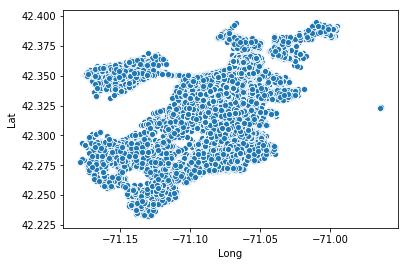

In [31]:
sns.scatterplot(data=data2,x='Long',y='Lat')
plt.show()

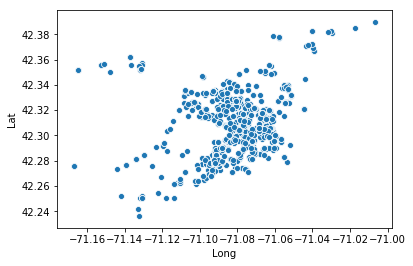

In [32]:
sns.scatterplot(data=data2[data2['SHOOTING']=='Y'],x='Long',y='Lat')
plt.show()

In [33]:
boston_map = folium.Map(location=[42.3, -71.1],zoom_start =12)
loc_shooting= data2[data2['SHOOTING']=='Y'][['Lat','Long']].values
loc_shooting =loc_shooting.tolist()
hm = plugins.HeatMap(loc_shooting)
hm.add_to(boston_map)
boston_map

Shooting crimes only happen in particular region, especially on the south of Boston central area, eg Dorchester